Sarrah Abdulali

Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
- Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import graphviz (wasn't working for me to install it in the terminal; a majority of us were having issues in class)

from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz 

In [40]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in

#import os
#os.listdir()
#print(os.getcwd())
#os.chdir('c:\\Users\\Brian Wright\\Documents\\3001Python\\DS-3001')

movie_metadata=pd.read_csv('/Users/Student/Downloads/DS-3001/data/movie_metadata.csv')
movie_metadatav2=pd.read_csv('/Users/Student/Downloads/DS-3001/data/movie_metadata.csv') #I use this later for getting top 3 movies



#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

In [41]:
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [42]:
movie_metadata.drop(['color', 'content_rating', 'genres', 'director_name', 'actor_2_name', 'movie_title', 'actor_1_name', 'actor_3_name', 'plot_keywords', 'movie_imdb_link'], axis=1, inplace=True)
movie_metadata.loc[movie_metadata['country'] != 'USA', 'country'] = 'foreign'
movie_metadata[["country"]] = OrdinalEncoder().fit_transform(movie_metadata[["country"]])
movie_metadata.loc[movie_metadata['language'] != 'English', 'language'] = 'non-English'
movie_metadata[["language"]] = OrdinalEncoder().fit_transform(movie_metadata[["language"]])
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     4993 non-null   float64
 1   duration                   5028 non-null   float64
 2   director_facebook_likes    4939 non-null   float64
 3   actor_3_facebook_likes     5020 non-null   float64
 4   actor_1_facebook_likes     5036 non-null   float64
 5   gross                      4159 non-null   float64
 6   num_voted_users            5043 non-null   int64  
 7   cast_total_facebook_likes  5043 non-null   int64  
 8   facenumber_in_poster       5030 non-null   float64
 9   num_user_for_reviews       5022 non-null   float64
 10  language                   5043 non-null   float64
 11  country                    5043 non-null   float64
 12  budget                     4551 non-null   float64
 13  title_year                 4935 non-null   float

#3 Check for missing variables and correct as needed.

c:\Users\Student\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


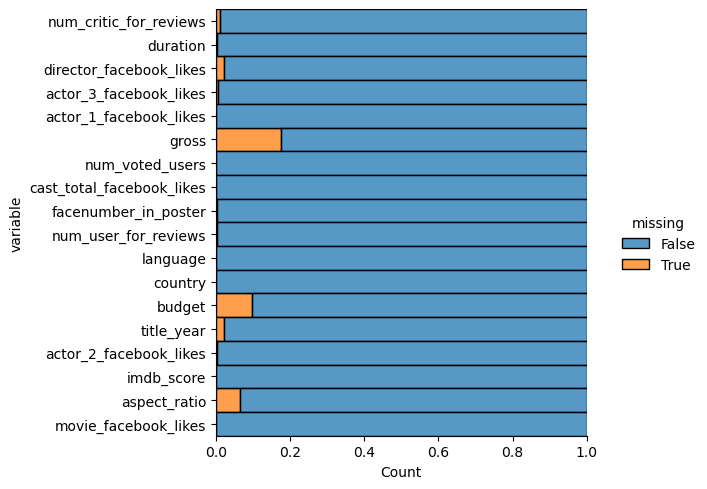

In [43]:
import seaborn as sns
sns.displot(
    data=movie_metadata.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [44]:
movie_metadata = movie_metadata.drop(['gross'], axis=1)
movie_metadata.dropna(axis = 0, how = 'any', inplace = True)

c:\Users\Student\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


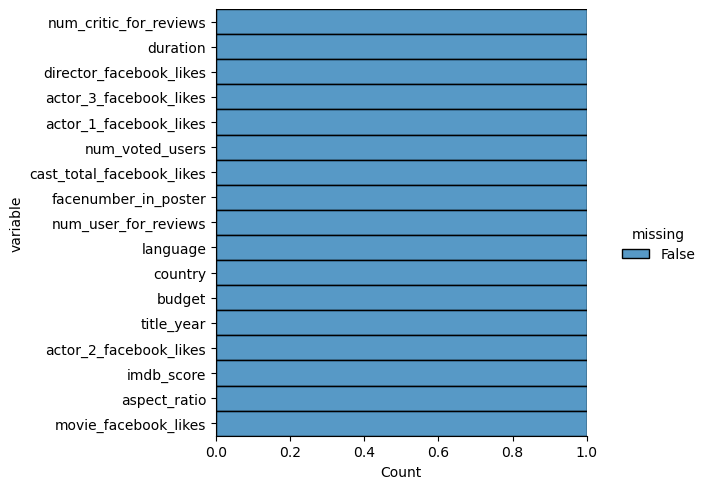

In [45]:
import seaborn as sns
sns.displot(
    data=movie_metadata.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the baserate or prevalence for the classifier, what does this number mean?

count    4284.000000
mean        6.453828
std         1.091188
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.300000
Name: imdb_score, dtype: float64

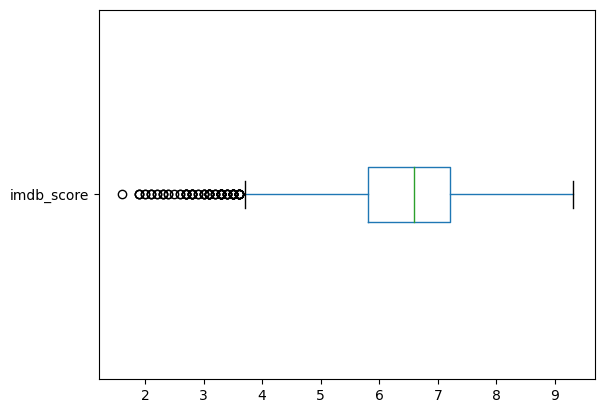

In [47]:
movie_metadata.boxplot(column= 'imdb_score', vert= False, grid=False)
movie_metadata.imdb_score.describe()

In [48]:
movie_metadata['imdb_score_f'] = pd.cut(movie_metadata.imdb_score, bins = [-10,7.2,10], labels =[0,1])
movie_metadata.drop(['imdb_score'], axis=1, inplace=True)
prevalence = movie_metadata.imdb_score_f.value_counts()[1]/len(movie_metadata.imdb_score_f)
prevalence

0.23529411764705882

Prevalence refers to the proportion or percentage of the positive class in the entire dataset of movies (23.5%). In the context of a binary classification problem (where you have two classes, typically denoted as positive and negative), the prevalence is the ratio of the number of positive instances to the total number of instances in the dataset.

In [49]:
x = movie_metadata.drop(columns = 'imdb_score_f', axis=1)
y = movie_metadata.imdb_score_f

#6 Split your data into test, tune, and train. (80/10/10)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, stratify= y, random_state=21)
x_tune, x_test, y_tune, y_test = train_test_split(x_test,y_test,  train_size = 0.50,stratify= y_test, random_state=49)

#7 Create the kfold object for cross validation.

In [51]:
kfold = RepeatedStratifiedKFold(n_splits=10,n_repeats =5, random_state=42)

#8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter 

In [52]:
scoring_metric = ['roc_auc','recall','balanced_accuracy']
depth_param= {"max_depth" : [1,2,3,4,5,6,7,8,9,10,11]}

#9 Build the classifier object 

In [54]:
#Classifier model we will use
myclassifier= DecisionTreeClassifier(random_state=1000)

#Set up search for best decisiontreeclassifier estimator across all of our folds based on roc_auc
mysearch = GridSearchCV(myclassifier, depth_param, scoring=scoring_metric, n_jobs=-1, cv=kf,refit='roc_auc')

#execute search on our training data, this may take a few seconds ...
mymodel = my_search.fit(x_train, y_train)

#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [57]:
bestest = my_model.best_estimator_
print(bestest)

DecisionTreeClassifier(max_depth=6, random_state=1000)


#11 Fit the model to the training data.

In [59]:
dotdata = export_graphviz(best, out_file =None,
               feature_names =x.columns, #feature names from dataset
               filled=True, 
                rounded=True, 
                class_names = ['bad_movies','good_movies']) #classification labels 
               
#graph=graphviz.Source(dot_data)
#graph

#12 What is the best depth value?

According to #10 it is 6! Also I couldn't get the plot earlier because of terminal issues with graphviz.

#13 Print out the model

#14 View the results, comment on how the model performed using several evaluation metrics.

In [60]:
auc = my_model.cv_results_['mean_test_roc_auc']
recall= my_model.cv_results_['mean_test_recall']
bal_acc= my_model.cv_results_['mean_test_balanced_accuracy']

sdauc = my_model.cv_results_['std_test_roc_auc']
sdrecall= my_model.cv_results_['std_test_recall']
sdbal_acc= my_model.cv_results_['std_test_balanced_accuracy']

#Parameter:
depth= np.unique(my_model.cv_results_['param_max_depth']).data

#Build DataFrame:
finalmodel = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,sdauc,sdrecall,sdbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

#See it
finalmodel.style.hide(axis='index')

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

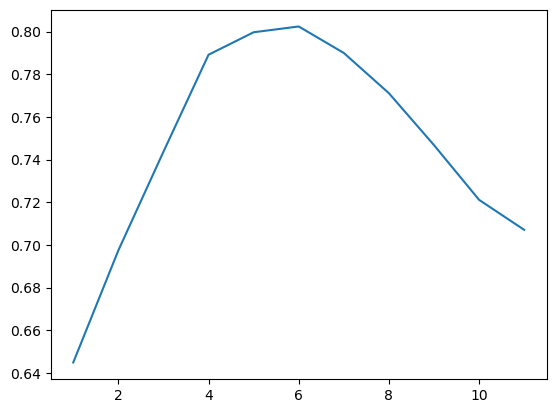

In [62]:
print(plt.plot(finalmodel.depth,finalmodel.auc))

#15 Which variables appear to be contributing the most (variable importance) 

In [63]:
variable_imp = pd.DataFrame(bestest.feature_importances_,index = x.columns,columns=['importance']).sort_values('importance', ascending=False)
print(variable_imp)

                           importance
num_voted_users              0.498604
budget                       0.168490
duration                     0.106115
title_year                   0.062303
language                     0.041685
movie_facebook_likes         0.025772
num_user_for_reviews         0.021924
num_critic_for_reviews       0.016045
cast_total_facebook_likes    0.014325
actor_1_facebook_likes       0.013752
actor_2_facebook_likes       0.010841
actor_3_facebook_likes       0.006998
country                      0.006858
director_facebook_likes      0.006288
facenumber_in_poster         0.000000
aspect_ratio                 0.000000


Axes(0.125,0.11;0.775x0.77)


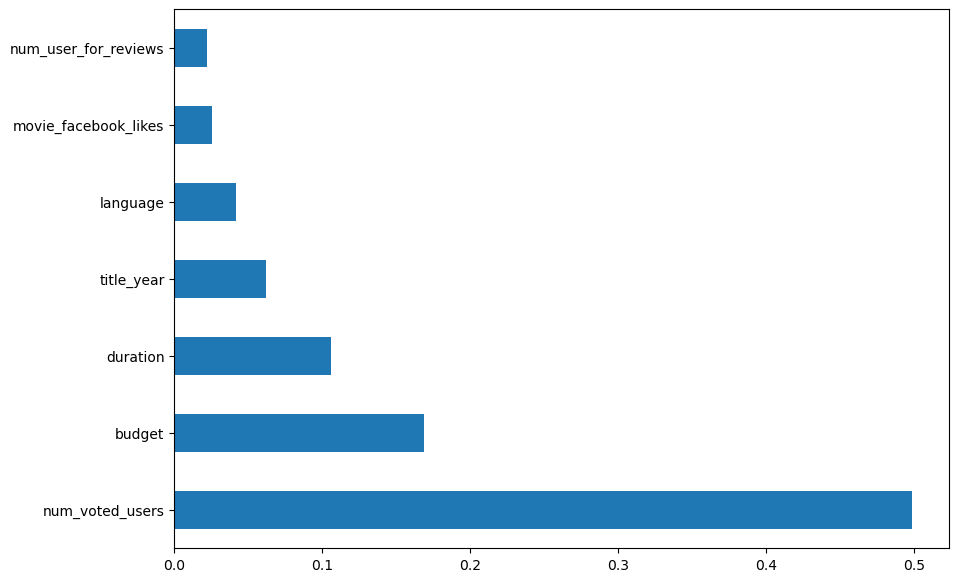

In [64]:
plt.figure(figsize=(10,7))
print(variable_imp.importance.nlargest(7).plot(kind='barh'))

#16 Use the predict method on the test data and print out the results.

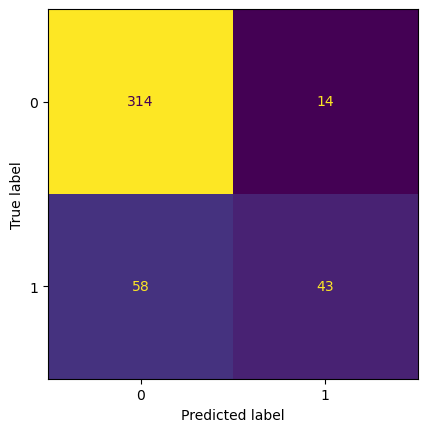

In [65]:
print(ConfusionMatrixDisplay.from_estimator(best,x_test,y_test,colorbar=False))

#17 How does the model perform on the test data?

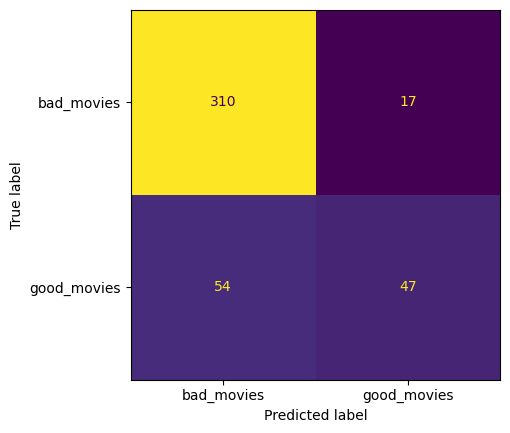

In [66]:
print(ConfusionMatrixDisplay.from_estimator(bestest,x_tune,y_tune, display_labels = ['bad_movies','good_movies'], colorbar=False))

#18 Print out the confusion matrix for the test data, what does it tell you about the model?

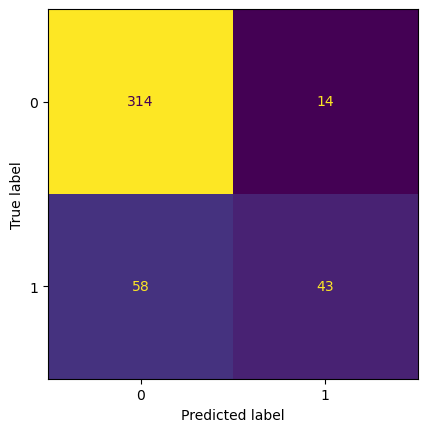

In [67]:
print(ConfusionMatrixDisplay.from_estimator(bestest,x_test,y_test,colorbar=False))

#19 What are the top 3 movies based on the test set? Which variables are most important in predicting the top 3 movies?

In [68]:
y_pred = bestest.predict(x_test)
test_data = x_test.copy()
test_data['predicted_imdb_score'] = y_pred
top_3_movies = test_data.sort_values(by='predicted_imdb_score', ascending=False).head(3)
top_3_movies['true_imdb_score']= y_test.loc[top_3_movies.index].values
top_3_movies['title'] = movie_metadatav2.loc[top_3_movies.index, 'movie_title'].values
top_3_movies

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,country,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,predicted_imdb_score,true_imdb_score,title
2005,280.0,122.0,0.0,407.0,12000.0,64944,13809,2.0,212.0,0.0,0.0,20000000.0,2009.0,463.0,1.85,6000,1,0,Bad Lieutenant: Port of Call New Orleans
2829,192.0,178.0,101.0,471.0,918.0,248354,2334,0.0,564.0,1.0,1.0,13500000.0,2004.0,653.0,1.85,14000,1,1,Downfall
1749,148.0,118.0,14000.0,237.0,11000.0,329969,11898,2.0,524.0,0.0,0.0,28000000.0,1984.0,429.0,2.35,0,1,1,Indiana Jones and the Temple of Doom


In [69]:
feature_imps = bestest.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_imps})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False)
top_3_movies_features = top_3_movies[x.columns]
top_features

,Feature,Importance
5,num_voted_users,0.498604
11,budget,0.168490
1,duration,0.106115
12,title_year,0.062303
9,language,0.041685
15,movie_facebook_likes,0.025772
8,num_user_for_reviews,0.021924
0,num_critic_for_reviews,0.016045
6,cast_total_facebook_likes,0.014325
4,actor_1_facebook_likes,0.013752


#20 Summarize what you learned along the way and make recommendations on how this could be used moving forward, being careful not to over promise.

A crucial lesson I gained through this experience is recognizing the significance of appropriately labeling variables and incorporating comments in my code for clarity. Although this model requires further refinement, its performance has not been that impressive. The confusion matrix revealed that the model's accuracy was lacking. Moving forward, I contemplate constructing the model, assessing feature importance, and subsequently rebuilding it, ensuring that only influential features affect the model. In summary, I believe understanding the importance of feature significance is the most valuable takeaway, and I am convinced it should not be underestimated in upcoming projects.